# Kaggle GI Tract Training Dataset
Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create a 2d dataframe
* create a 3d dataframe (to do)


In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import torch
from PIL import Image
#from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

DATASET_FOLDER = Path("/kaggle/input/uw-madison-gi-tract-image-segmentation")
#DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

WORKING_FOLDER = Path('./')


# Data

## Process the Metadata

In [2]:
df = pd.read_csv(DATASET_FOLDER/"train.csv")
display(df.head())

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


### Unstack the data
Ensure all segmentations for the same slice are on a single row

In [3]:
pivoted = df.pivot(index="id", columns="class", values="segmentation")

In [4]:
#Inspect that this worked
pivoted.dropna()

class,large_bowel,small_bowel,stomach
id,,,
case101_day20_slice_0091,24687 4 24950 10 25215 13 25480 15 25745 17 26...,25662 3 25927 5 26192 6 26458 10 26723 12 2698...,18772 25 19036 32 19301 36 19566 40 19831 43 2...
case101_day20_slice_0092,24952 7 25216 11 25481 14 25746 16 26011 18 26...,25395 2 25660 4 25925 6 26191 9 26456 11 26722...,18509 12 18769 28 19034 34 19299 38 19564 42 1...
case101_day20_slice_0093,24686 8 24950 12 25215 14 25480 16 25745 18 26...,25924 3 26190 4 26455 6 26719 11 26984 15 2724...,19033 28 19297 35 19562 39 19827 43 20092 47 2...
case101_day20_slice_0094,24156 4 24419 10 24683 13 24948 15 25213 17 25...,26184 4 26450 6 26715 8 26981 10 27246 14 2751...,19034 17 19297 27 19561 34 19825 40 20090 46 2...
case101_day20_slice_0095,24153 7 24417 11 24682 14 24948 14 25213 16 25...,26184 4 26449 7 26715 8 26980 11 27245 14 2751...,19296 23 19560 29 19825 35 20089 42 20354 47 2...
...,...,...,...
case9_day22_slice_0070,23209 2 23564 9 23922 13 24281 18 24641 21 250...,43657 12 44016 15 44375 17 44735 17 45095 17 4...,26416 3 26776 4 27135 6 27495 6 27855 7 28216 ...
case9_day22_slice_0071,23203 9 23562 11 23921 15 24280 20 24640 23 25...,43657 5 44016 9 44376 13 44736 14 45096 14 454...,31467 5 31826 7 32186 9 32545 11 32905 15 3326...
case9_day22_slice_0072,22845 6 23202 11 23561 13 23920 17 24279 22 24...,44380 5 44738 10 45097 12 45457 12 45817 12 46...,34001 1 34358 7 34715 12 35073 16 35431 19 357...


In [5]:
#Use the pivoted data going forward
df = pivoted
df['id'] = df.index

### Parse out the metadata

In [6]:
#Get Case-ID as columns (str and int)
df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
df["case_id"] = df["case_id_str"].apply(lambda x: int(x[4::]))

#Get Day as columns (str and int)
df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
df["day_num"] = df["day_num_str"].apply(lambda x: int(x[3::]))

#Get Slice Identifier as columns (str and int)
df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
df["slice_num"] = df["slice_id"].apply(lambda x: int(x[6::]))

# Create the path to get to the file
df['match'] = df.case_id_str + '/' + df.case_id_str + '_' + df.day_num_str + '/scans/' + df.slice_id

In [7]:
df

class,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
id,,,,,,,,,,,
case101_day20_slice_0001,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001
case101_day20_slice_0002,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002
case101_day20_slice_0003,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003
case101_day20_slice_0004,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004
case101_day20_slice_0005,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005
...,...,...,...,...,...,...,...,...,...,...,...
case9_day22_slice_0140,NaN,NaN,NaN,case9_day22_slice_0140,case9,9,day22,22,slice_0140,140,case9/case9_day22/scans/slice_0140
case9_day22_slice_0141,NaN,NaN,NaN,case9_day22_slice_0141,case9,9,day22,22,slice_0141,141,case9/case9_day22/scans/slice_0141
case9_day22_slice_0142,NaN,NaN,NaN,case9_day22_slice_0142,case9,9,day22,22,slice_0142,142,case9/case9_day22/scans/slice_0142


### Get the metadata from the files

In [8]:
all_imgs = glob.glob(os.path.join(str(DATASET_FOLDER), "train", "case*", "case*_day*", "scans", "*.png"))
all_imgs = [p.replace(str(DATASET_FOLDER)+'/train/', "") for p in all_imgs]

#check that they match in count
print(f"images: {len(all_imgs)}")
print(f"metadata: {len(df['id'].unique())}")

images: 38496
metadata: 38496


In [9]:
file_df = pd.DataFrame(all_imgs)

In [10]:
file_df.columns = ["subpath"]

In [11]:
file_df

,subpath
0,case36/case36_day14/scans/slice_0006_266_266_1...
1,case36/case36_day14/scans/slice_0082_266_266_1...
2,case36/case36_day14/scans/slice_0113_266_266_1...
3,case36/case36_day14/scans/slice_0076_266_266_1...
4,case36/case36_day14/scans/slice_0125_266_266_1...
...,...
38491,case33/case33_day21/scans/slice_0045_266_266_1...
38492,case33/case33_day21/scans/slice_0027_266_266_1...
38493,case33/case33_day21/scans/slice_0089_266_266_1...
38494,case33/case33_day21/scans/slice_0123_266_266_1...


In [12]:
file_df['filename'] = file_df["subpath"].apply(lambda x: x.split("/")[-1])

In [13]:
def trunc_at(s, n=3):
    "Returns s truncated at the n'th (3rd by default) occurrence of the delimiter, d."
    return '_'.join(s.split('_', n)[:n])

In [14]:
file_df["match"] = file_df["subpath"].apply(trunc_at)

In [15]:
#Get image slice height in pixels
file_df["im_height"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[2]))

#Get image slice width in pixels
file_df["im_width"] = file_df["filename"].apply(lambda x: int(x.split("_", 5)[3]))

#Get image pixel height in mm
file_df["im_pixel_height"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[4]))

#Get image pixel width in mm
file_df["im_pixel_width"] = file_df["filename"].apply(lambda x: float(x.split("_", 5)[5].split(".png",1)[0]))

#Define physical slice thickness in mm (3.0 mm for all files)
file_df["slice_thickness"] = 3.0

In [16]:
file_df

,subpath,filename,match,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness
0,case36/case36_day14/scans/slice_0006_266_266_1...,slice_0006_266_266_1.50_1.50.png,case36/case36_day14/scans/slice_0006,266,266,1.5,1.5,3.0
1,case36/case36_day14/scans/slice_0082_266_266_1...,slice_0082_266_266_1.50_1.50.png,case36/case36_day14/scans/slice_0082,266,266,1.5,1.5,3.0
2,case36/case36_day14/scans/slice_0113_266_266_1...,slice_0113_266_266_1.50_1.50.png,case36/case36_day14/scans/slice_0113,266,266,1.5,1.5,3.0
3,case36/case36_day14/scans/slice_0076_266_266_1...,slice_0076_266_266_1.50_1.50.png,case36/case36_day14/scans/slice_0076,266,266,1.5,1.5,3.0
4,case36/case36_day14/scans/slice_0125_266_266_1...,slice_0125_266_266_1.50_1.50.png,case36/case36_day14/scans/slice_0125,266,266,1.5,1.5,3.0
...,...,...,...,...,...,...,...,...
38491,case33/case33_day21/scans/slice_0045_266_266_1...,slice_0045_266_266_1.50_1.50.png,case33/case33_day21/scans/slice_0045,266,266,1.5,1.5,3.0
38492,case33/case33_day21/scans/slice_0027_266_266_1...,slice_0027_266_266_1.50_1.50.png,case33/case33_day21/scans/slice_0027,266,266,1.5,1.5,3.0
38493,case33/case33_day21/scans/slice_0089_266_266_1...,slice_0089_266_266_1.50_1.50.png,case33/case33_day21/scans/slice_0089,266,266,1.5,1.5,3.0
38494,case33/case33_day21/scans/slice_0123_266_266_1...,slice_0123_266_266_1.50_1.50.png,case33/case33_day21/scans/slice_0123,266,266,1.5,1.5,3.0


In [17]:
#create our final dataframe by joining the two dataframes
df2d = pd.merge(df, file_df, on = "match", how = "inner")

In [18]:
# Identify images without segmentation
#For each row find segmentations for each organ
sel1 = ~df2d.large_bowel.isnull()
sel2 = ~df2d.small_bowel.isnull()
sel3 = ~df2d.stomach.isnull()

# select rows with segments
sel_segments = sel1 | sel2 | sel3

#create a new column reflecting whether segmentations exist
df2d['segmentations'] = sel_segments

In [19]:
df2d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations'],
      dtype='object')

In [20]:
with pd.option_context('display.max_rows', 50, 'display.max_columns', 100):
    display(df2d)

,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations
0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,1,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False
1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,2,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False
2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,3,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False
3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,4,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False
4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,5,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,NaN,NaN,NaN,case9_day22_slice_0140,case9,9,day22,22,slice_0140,140,case9/case9_day22/scans/slice_0140,case9/case9_day22/scans/slice_0140_360_310_1.5...,slice_0140_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,False
38492,NaN,NaN,NaN,case9_day22_slice_0141,case9,9,day22,22,slice_0141,141,case9/case9_day22/scans/slice_0141,case9/case9_day22/scans/slice_0141_360_310_1.5...,slice_0141_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,False
38493,NaN,NaN,NaN,case9_day22_slice_0142,case9,9,day22,22,slice_0142,142,case9/case9_day22/scans/slice_0142,case9/case9_day22/scans/slice_0142_360_310_1.5...,slice_0142_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,False
38494,NaN,NaN,NaN,case9_day22_slice_0143,case9,9,day22,22,slice_0143,143,case9/case9_day22/scans/slice_0143,case9/case9_day22/scans/slice_0143_360_310_1.5...,slice_0143_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,False


## Do some EDA

### Review segmentations by organ in each file

In [21]:



df_sel = pd.concat([sel1, sel2, sel3], axis=1)
display(df_sel)

#Here are the number of observations for each combination
combos = df_sel.groupby(['large_bowel', 'small_bowel','stomach']).size().reset_index(name='num_obs').sort_values('num_obs',ascending=False)
display(combos)

,large_bowel,small_bowel,stomach
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
38491,False,False,False
38492,False,False,False
38493,False,False,False
38494,False,False,False


,large_bowel,small_bowel,stomach,num_obs
0,False,False,False,21906
6,True,True,False,7781
7,True,True,True,3201
5,True,False,True,2980
1,False,False,True,2286
3,False,True,True,160
4,True,False,False,123
2,False,True,False,59


In [22]:
#Helper Function to decode RLE
def rle_decode(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    
    img = np.zeros(shape[0]*shape[1],dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)

In [23]:
def create_mask_image(row):
    classes = ['large_bowel', 'small_bowel', 'stomach']
    

    img = plt.imread(TRAIN_FOLDER/row['subpath'])
    #pimg = cv.imread(path) ## why
    
    lb_class_seg = row['large_bowel']
    sb_class_seg = row['small_bowel']
    st_class_seg = row['stomach']    
    print(img.shape)
    arr = np.zeros((img.shape[0], img.shape[1], 3),dtype='uint8')
    
    if type(lb_class_seg) is str:
        arr[:,:,0] = rle_decode(lb_class_seg,img.shape, color_val=255)

    if type(sb_class_seg) is str:
        arr[:,:,1] = rle_decode(sb_class_seg, img.shape,color_val=255)
        
    if type(lb_class_seg) is str:
        arr[:,:,2] = rle_decode(st_class_seg, img.shape,color_val=255)
        
    return arr
    

In [24]:
#Visualize Saved Images and masks
def vis_image(row):
    img = plt.imread(TRAIN_FOLDER/row['subpath'])
    mask = create_mask_image(row)
    ratio = row.im_pixel_width/row.im_pixel_height
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img,cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {img.shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, aspect=ratio)
    plt.title(f"Mask Shape = {mask.shape}")
    plt.axis('off')
    print(f"Image max: {img.max()} \tImage min: {img.min()}\nMask max: {mask.max()} \tMask min: {mask.min()} \tMask unique values: {np.unique(mask)}")
    print(row)

### Check out the files that are of height 360 pixels

In [25]:
sel = (sel1) & (sel2) & (sel3) & (df2d.im_height==360)

In [26]:
x = df2d[sel]

In [27]:
x

,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations
665,33261 3 33619 7 33978 9 34338 10 34697 12 3505...,35087 3 35445 7 35804 8 36163 10 36522 11 3688...,33726 11 34084 15 34443 18 34802 19 35161 21 3...,case102_day0_slice_0090,case102,102,day0,0,slice_0090,90,case102/case102_day0/scans/slice_0090,case102/case102_day0/scans/slice_0090_360_310_...,slice_0090_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
666,32541 4 32899 8 33257 12 33615 14 33974 16 343...,34728 3 35086 7 35445 9 35804 10 36163 11 3652...,33366 9 33725 12 34083 16 34442 18 34801 20 35...,case102_day0_slice_0091,case102,102,day0,0,slice_0091,91,case102/case102_day0/scans/slice_0091,case102/case102_day0/scans/slice_0091_360_310_...,slice_0091_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
667,32539 8 32897 11 33256 13 33615 15 33974 17 34...,34726 6 35085 8 35444 10 35803 11 36162 12 365...,33007 9 33364 14 33723 17 34082 19 34441 21 34...,case102_day0_slice_0092,case102,102,day0,0,slice_0092,92,case102/case102_day0/scans/slice_0092,case102/case102_day0/scans/slice_0092_360_310_...,slice_0092_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
668,31462 3 31819 9 32178 11 32536 14 32895 16 332...,34727 6 35086 8 35445 10 35804 11 36163 12 365...,32648 4 33004 11 33363 14 33722 16 34081 18 34...,case102_day0_slice_0093,case102,102,day0,0,slice_0093,93,case102/case102_day0/scans/slice_0093,case102/case102_day0/scans/slice_0093_360_310_...,slice_0093_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
669,31464 2 31820 9 32178 13 32536 16 32895 18 332...,34368 6 34727 9 35085 14 35444 16 35804 16 361...,32646 7 33003 12 33361 16 33720 19 34079 21 34...,case102_day0_slice_0094,case102,102,day0,0,slice_0094,94,case102/case102_day0/scans/slice_0094,case102/case102_day0/scans/slice_0094_360_310_...,slice_0094_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38421,23209 2 23564 9 23922 13 24281 18 24641 21 250...,43657 12 44016 15 44375 17 44735 17 45095 17 4...,26416 3 26776 4 27135 6 27495 6 27855 7 28216 ...,case9_day22_slice_0070,case9,9,day22,22,slice_0070,70,case9/case9_day22/scans/slice_0070,case9/case9_day22/scans/slice_0070_360_310_1.5...,slice_0070_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
38422,23203 9 23562 11 23921 15 24280 20 24640 23 25...,43657 5 44016 9 44376 13 44736 14 45096 14 454...,31467 5 31826 7 32186 9 32545 11 32905 15 3326...,case9_day22_slice_0071,case9,9,day22,22,slice_0071,71,case9/case9_day22/scans/slice_0071,case9/case9_day22/scans/slice_0071_360_310_1.5...,slice_0071_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
38423,22845 6 23202 11 23561 13 23920 17 24279 22 24...,44380 5 44738 10 45097 12 45457 12 45817 12 46...,34001 1 34358 7 34715 12 35073 16 35431 19 357...,case9_day22_slice_0072,case9,9,day22,22,slice_0072,72,case9/case9_day22/scans/slice_0072,case9/case9_day22/scans/slice_0072_360_310_1.5...,slice_0072_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True
38424,22488 2 22843 9 23201 12 23559 16 23918 21 242...,43661 2 44019 6 44378 9 44738 13 45098 14 4545...,35075 4 35434 13 35793 16 36153 17 36513 17 36...,case9_day22_slice_0073,case9,9,day22,22,slice_0073,73,case9/case9_day22/scans/slice_0073,case9/case9_day22/scans/slice_0073_360_310_1.5...,slice_0073_360_310_1.50_1.50.png,360,310,1.5,1.5,3.0,True


In [28]:
df2d.index.get_loc(665)

665

(310, 360)
Image max: 0.010772869922220707 	Image min: 0.0
Mask max: 255 	Mask min: 0 	Mask unique values: [  0 255]
large_bowel        33261 3 33619 7 33978 9 34338 10 34697 12 3505...
small_bowel        35087 3 35445 7 35804 8 36163 10 36522 11 3688...
stomach            33726 11 34084 15 34443 18 34802 19 35161 21 3...
id                                           case102_day0_slice_0090
case_id_str                                                  case102
case_id                                                          102
day_num_str                                                     day0
day_num                                                            0
slice_id                                                  slice_0090
slice_num                                                         90
match                          case102/case102_day0/scans/slice_0090
subpath            case102/case102_day0/scans/slice_0090_360_310_...
filename                            slice_0090_360_310_

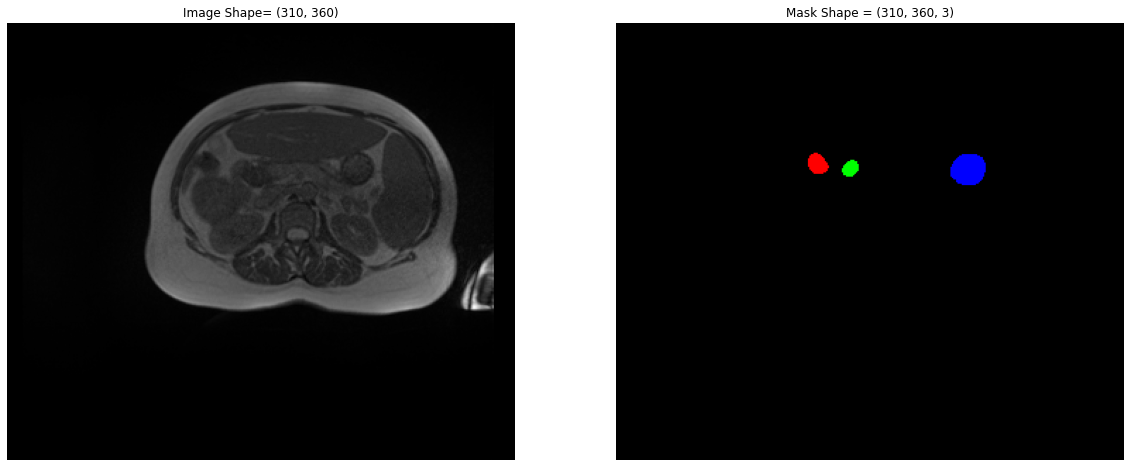

In [29]:
vis_image(df2d.iloc[665])

In [30]:
# Per this notebook this data is faulty
# https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-train-pytorch/notebook
fault1 = 'case7_day0'
fault2 = 'case81_day30'

# Should we remove it?

In [31]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [32]:
# Check that encode and decode are inverses
mask_im = create_mask_image(df2d.iloc[665])
s0 = rle_encode(mask_im[:,:,0])
mask_im2 = np.zeros_like(mask_im)
im = rle_decode(s0, mask_im[:,:,0].shape,color_val=255)

#Check for match between original mask image and orig mask image encoded as rle then decoded
# Sum of 0 means all pixels matched
np.sum(im != mask_im[:,:,0])

(310, 360)


0

In [33]:
#Find distinct combinations of image heights and widths
df2d[['im_height', 'im_width', 'im_pixel_height', 'im_pixel_width']].drop_duplicates()

,im_height,im_width,im_pixel_height,im_pixel_width
0,266,266,1.50,1.50
576,360,310,1.50,1.50
3744,276,276,1.63,1.63
11856,234,234,1.50,1.50


In [34]:
combos = df2d.groupby(['im_height', 'im_width', 'im_pixel_height', 'im_pixel_width']).size().reset_index(name='num_obs').sort_values('num_obs',ascending=False)
display(combos)

,im_height,im_width,im_pixel_height,im_pixel_width,num_obs
1,266,266,1.50,1.50,25920
3,360,310,1.50,1.50,11232
2,276,276,1.63,1.63,1200
0,234,234,1.50,1.50,144


## Training and Validation set splitting

In [35]:
n_folds = 5
seed = 42

In [36]:
#We will use n fold cross validation, which will create 5 training sets of 80% of the data
# and 5 validation sets of 20% of the data.
# We use the case ID to stratify the folds so that cases are not split between training and val sets

skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df2d, df2d['segmentations'], groups = df["case_id"])):
    df2d.loc[val_idx, 'fold'] = fold


In [37]:
display(df2d.groupby(['fold','segmentations'])['id'].count())

fold  segmentations
0.0   False            4857
      True             4007
1.0   False            4951
      True             3945
2.0   False            3692
      True             2788
3.0   False            4232
      True             2936
4.0   False            4174
      True             2914
Name: id, dtype: int64

## Output the final file for training

In [38]:
df2d.to_csv(WORKING_FOLDER/"df2d_metadata.csv")